<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/ProduzGraficos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import json
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import regex as re

# Carrega arquivo de saída (resultados)

In [71]:
# CONSTANTES DOS RESULTADOS

REDE_CNN = 'CNN'
REDE_LSTM = 'LSTM'
REDE_BILSTM = 'Bi-LSTM'

BASE_1 = 'BASE 1'
BASE_2 = 'BASE 2'

FUNCAO_ATV_SIGMOID = 'SIGMOID'
FUNCAO_ATV_SOFTMAX = 'SOFTMAX'
FUNCAO_ATV_RELU = 'RELU'

OTIMIZADOR_1 = '1'
OTIMIZADOR_2 = '2'
OTIMIZADOR_3 = '3'
OTIMIZADOR_4 = '4'

# Caminho arquivo de saída
PATH_ARQ_SAIDA = "/content/drive/MyDrive/TCC/resultados/resultados.csv"

resultados = pd.read_csv(PATH_ARQ_SAIDA, index_col=0)
resultados.head()

,rede,base,funcao_ativacao,otimizador,acuracia,roc_curve,train_resume,confusion_matrix1,confusion_matrix2
0,CNN,BASE 2,SIGMOID,1,0.922459,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...",[966 81],[ 83 985]
1,CNN,BASE 2,SIGMOID,1,0.922931,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...",[965 82],[ 81 987]


In [72]:
# Plot de Gráficos

def plot_accuracy(history):
    _,accuracy,loss,val_accuracy,val_loss = list(history.keys())
    acc = list(history[accuracy].values())
    test_acc = list(history[val_accuracy].values())
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('accuracy') 
    plt.xlabel('epoch')
    plt.show()

def plot_loss(history):
    _,accuracy,loss,val_accuracy,val_loss = list(history.keys())
    loss = list(history[loss].values())
    val_loss = list(history[val_loss].values())
    epochs = range(len(loss))
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('loss') 
    plt.xlabel('epoch')
    plt.show()

def plot_roc_curve(roc_curve):        
    plt.figure()
    lw = 2
    'false_positive_rate', 'true_positive_rate', 'score'
    false_positive_rate, true_positive_rate, score = list(roc_curve.keys())
    false_positive_rate = roc_curve[false_positive_rate]
    true_positive_rate = roc_curve[true_positive_rate]
    score = roc_curve[score]
    plt.plot(false_positive_rate, true_positive_rate, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % score)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

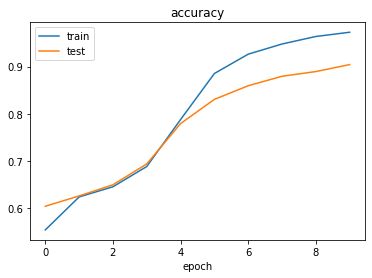

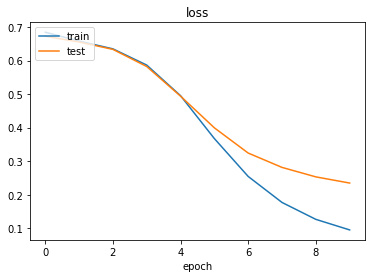

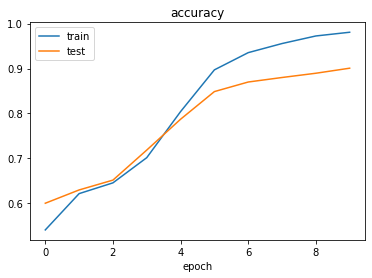

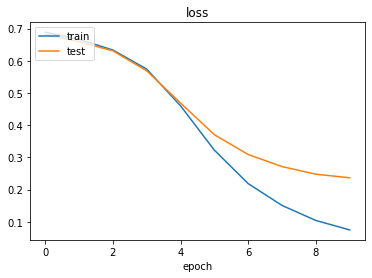

In [73]:
for train_resume in resultados.train_resume:
  plot_accuracy(json.loads(train_resume))
  plot_loss(json.loads(train_resume))

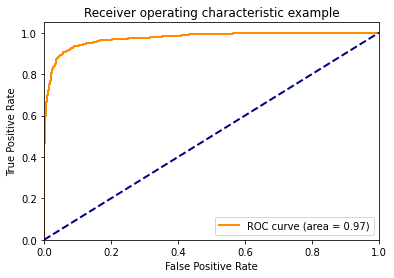

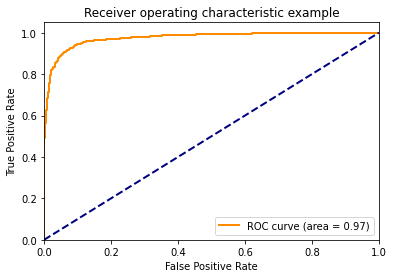

In [74]:
for roc_curve in resultados.roc_curve:
  a =json.loads(roc_curve)
  plot_roc_curve(a)

<class 'numpy.ndarray'>
[[966  81]
 [ 83 985]]


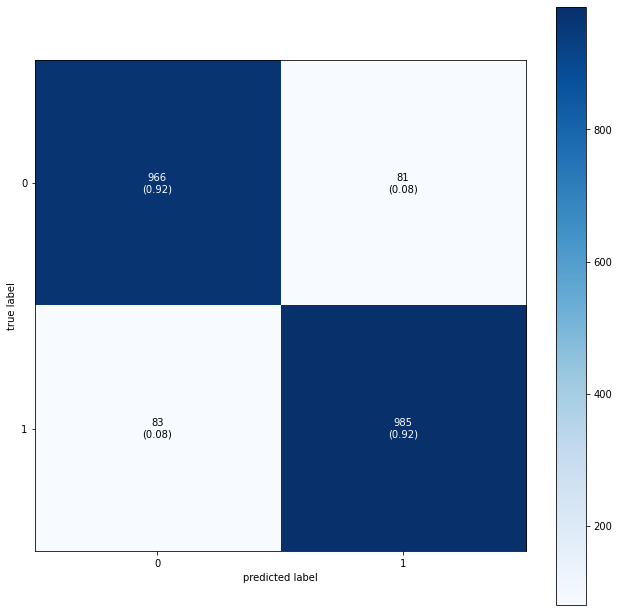

<class 'numpy.ndarray'>
[[965  82]
 [ 81 987]]


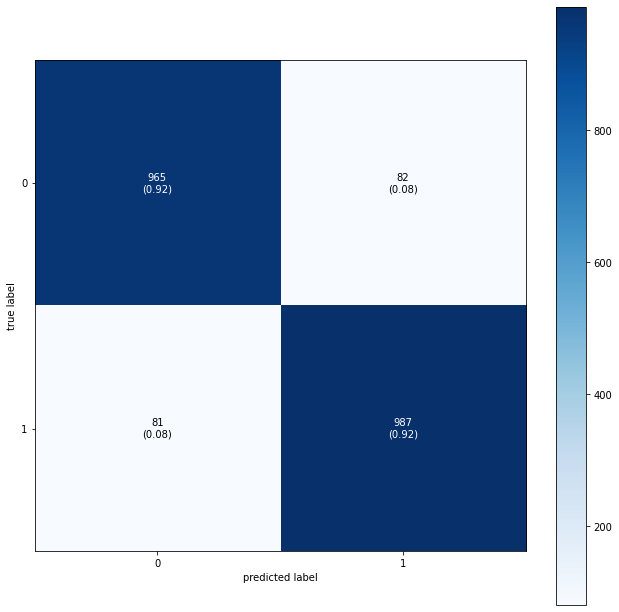

In [76]:
for confusion_matrix1,confusion_matrix2 in zip(resultados.confusion_matrix1,resultados.confusion_matrix2):
  confusion_matrix1 = re.findall(r'\d+',confusion_matrix1)
  confusion_matrix1 = np.array([int(confusion_matrix1[0]),int(confusion_matrix1[1])])

  confusion_matrix2 = re.findall(r'\d+',confusion_matrix2)
  confusion_matrix2 = np.array([int(confusion_matrix2[0]),int(confusion_matrix2[1])])

  confusion_matrix = np.array([confusion_matrix1,confusion_matrix2])

  print(type(confusion_matrix))
  print(confusion_matrix)
  fig,ax = plot_confusion_matrix(figsize=(11, 11),conf_mat=confusion_matrix,
                                  colorbar=True,
                                  show_absolute=True,
                                  show_normed=True,
                                )
  plt.show()